<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C6/C6.html"><img src="../data/C6_nav.png" width="100"  style="float:right;" alt="C6"></a>
<h1>Complex-Domain Novelty</h1> 
</div>

<br/>

<p>
Following Section 6.1.4 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook a complex-domain approach for computing a novelty function.   
</p> 

## Phase and Magnitude

We have seen that steady regions within a signal may be  characterized by a [phase-based criterion](../C6/C6S1_NoveltyPhase.html) in the case that the sinusoid correlates well with the signal. However, if the magnitude of the Fourier coefficient $\mathcal{X}(n,k)$ is very small, the phase $\varphi(n,k)$ may exhibit a rather chaotic behavior due to small noise-like fluctuations that may occur even within a steady region of the signal. To obtain a more robust detector, one idea is to weight the  **phase** information with the **magnitude** of the spectral coefficient. This leads to a complex-domain variant of the novelty function, which jointly considers phase and magnitude. The assumption of this variant is that the phase differences as well as the magnitude stay more or less constant in steady regions. Therefore, given the Fourier coefficient $\mathcal{X}(n,k)$, one obtains a steady-state estimate $\hat{\mathcal{X}}(n+1,k)$ for the next frame by setting

\begin{eqnarray}
   \varphi'(n,k) &:=& \varphi(n,k)- \varphi(n-1,k), \\
   \hat{\mathcal{X}}(n+1,k) &:=& |\mathcal{X}(n,k)|\,\, \mathrm{exp}(2\pi i(\varphi(n,k)+\varphi'(n,k))),
\end{eqnarray}

Then, we can use the magnitude between the estimate $\hat{\mathcal{X}}(n+1,k)$ and the actual coefficient $\mathcal{X}(n+1,k)$ to obtain a **measure of novelty**:

\begin{equation}
   \mathcal{X}'(n+1,k) = |\hat{\mathcal{X}}(n+1,k)-\mathcal{X}(n+1,k)|.
\end{equation}

The complex-domain difference $\mathcal{X}'(n,k)$ quantifies the degree of nonstationarity for frame $n$ and coefficient $k$. The following figure illustrates the definitions:

<img src="../data/C6/FMP_C6_F10.png" width="350px" align="middle" alt="FMP_C6_F10.png">

## Complex-Domain Novelty Function

Note that this number does not discriminate between note onsets (**energy increase**) and note offsets (**energy decrease**). Therefore, we decompose $\mathcal{X}'(n,k)$ into a component $\mathcal{X}^+(n,k)$ of increasing magnitude and a component $\mathcal{X}^-(n,k)$ of decreasing magnitude:

\begin{eqnarray}
   \mathcal{X}^+(n,k) =  \left\{ \begin{array}{cl}
                \mathcal{X}'(n,k) & \, \mbox{for $|\mathcal{X}(n,k)|>|\mathcal{X}(n-1,k)|$}\\
                 0 & \, \mbox{otherwise,} 
                 \end{array} \right.\\  
   \mathcal{X}^-(n,k) =  \left\{ \begin{array}{cl}
                \mathcal{X}'(n,k) & \, \mbox{for $|\mathcal{X}(n,k)|\leq |\mathcal{X}(n-1,k)|$}\\
                 0 & \, \mbox{otherwise.} 
                 \end{array} \right.
\end{eqnarray}

A **complex-domain novelty function** $\Delta_\mathrm{Complex}$ for detecting note onsets can then be defined by 
summing the values $\mathcal{X}^+(n,k)$ over all frequency coefficients:

\begin{equation}
   \Delta_\mathrm{Complex}(n,k) = \sum_{k=0}^{K}\mathcal{X}^+(n,k).
\end{equation}

Similarly, for detecting general transients or note offsets, one may compute a novelty function using  $\mathcal{X}'(n,k)$ or $\mathcal{X}^-(n,k)$, respectively.

## Implementation

In the following code cell, one finds an implementation of this idea. As for the [spectral-based novelty function](../C6/C6S1_NoveltySpectral.html), one may add further processing steps such as logarithmic compression of the magnitude, subtracting a local average, and normalization dividing the curve by its maximum value.

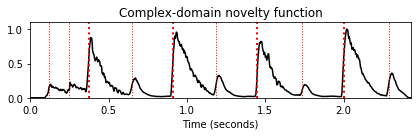

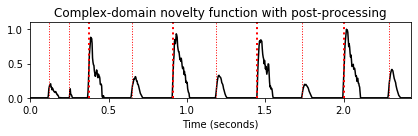

In [1]:
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import IPython.display as ipd

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
from libfmp.c6 import compute_local_average

%matplotlib inline

def compute_novelty_complex(x, Fs=1, N=1024, H=64, gamma=10.0, M=40, norm=True):
    """Compute complex-domain novelty function

    Notebook: C6/C6S1_NoveltyComplex.ipynb

    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate (Default value = 1)
        N (int): Window size (Default value = 1024)
        H (int): Hop size (Default value = 64)
        gamma (float): Parameter for logarithmic compression (Default value = 10.0)
        M (int): Determines size (2M+1) in samples of centric window used for local average (Default value = 40)
        norm (bool): Apply max norm (if norm==True) (Default value = True)

    Returns:
        novelty_complex (np.ndarray): Energy-based novelty function
        Fs_feature (scalar): Feature rate
    """
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Fs_feature = Fs / H
    mag = np.abs(X)
    if gamma > 0:
        mag = np.log(1 + gamma * mag)
    phase = np.angle(X) / (2*np.pi)
    phase_diff = np.diff(phase, axis=1)
    phase_diff = np.concatenate((phase_diff, np.zeros((phase.shape[0], 1))), axis=1)
    X_hat = mag * np.exp(2*np.pi*1j*(phase+phase_diff))
    X_prime = np.abs(X_hat - X)
    X_plus = np.copy(X_prime)
    for n in range(1, X.shape[0]):
        idx = np.where(mag[n, :] < mag[n-1, :])
        X_plus[n, idx] = 0
    novelty_complex = np.sum(X_plus, axis=0)
    if M > 0:
        local_average = compute_local_average(novelty_complex, M)
        novelty_complex = novelty_complex - local_average
        novelty_complex[novelty_complex < 0] = 0
    if norm:
        max_value = np.max(novelty_complex)
        if max_value > 0:
            novelty_complex = novelty_complex / max_value
    return novelty_complex, Fs_feature

fn_ann = os.path.join('..', 'data', 'C6', 'FMP_C6_F01_Queen.csv')
ann, label_keys = libfmp.c6.read_annotation_pos(fn_ann)

fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F01_Queen.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs)
x_duration = len(x)/Fs

nov, Fs_nov = compute_novelty_complex(x, Fs=Fs, gamma=10, M=0, norm=1) 
fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', 
                    title='Complex-domain novelty function')
libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys, 
                    nontime_axis=True, time_min=0, time_max=x_duration);

nov, Fs_nov = compute_novelty_complex(x, Fs=Fs, gamma=10, M=40, norm=1) 
fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', 
                    title='Complex-domain novelty function with post-processing')
libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys,  
                    nontime_axis=True, time_min=0, time_max=x_duration);

## Further Notes

* In the [FMP notebook on onset detection](../C6/C6S1_OnsetDetection.html), one finds an introduction to the task of onset detection. 
* In the [FMP notebook on novelty comparison](../C6/C6S1_NoveltyComparison.html), we compare different novelty detection approaches.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Angel Villar-Corrales.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>